
# This notebook deals with finding the best classification technique to figure out the survivors of the titanic

## Description of each column
 Variable------ >Definition	Key
 
 survival------> Survival	0 = No, 1 = Yes      <------------------TARGET VARIABLE
 
 pclass------>	  Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
 
 sex------>	        Sex	
 
 Age------>	        Age in years	
 
 sibsp------>	    # of siblings / spouses aboard the Titanic	
 
 parch------>	    # of parents / children aboard the Titanic	
 
 ticket------>	    Ticket number	
 
 fare------>	    Passenger fare	
 
 cabin------>	    Cabin number	
 
 embarked------>	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

## Importing the libraries and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
import scipy.stats as sts
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC 

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import resample
from scipy.stats import randint
from sklearn.metrics import accuracy_score,f1_score
from scipy.stats import loguniform

sns.set(color_codes=True)
sns.set_palette("deep")

## Importing the datasets

In [2]:
read_train=pd.read_csv(r'C:\Users\Hp\Desktop\DATA SCIENCE DOCS\.csv Files\titanic\train.csv',low_memory=True)
read_test=pd.read_csv(r'C:\Users\Hp\Desktop\DATA SCIENCE DOCS\.csv Files\titanic\test.csv',low_memory=True)
test_df=pd.DataFrame(read_test)

In [3]:
train_df=pd.DataFrame(read_train)
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Outlier detection in current numerical columns using TUKEY METHOD

In [4]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_df,2,["Age","SibSp","Parch","Fare"])

#locate the outliers
train_df.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [6]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
876,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
877,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
878,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
879,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Check for missing values and info in general

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [8]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

#### Show description of non numerical/categorical variables

In [9]:
train_df.describe(include=['O'])    # include=['O'] implies only categorical/non numerical values

,Name,Sex,Ticket,Cabin,Embarked
count,881,881,881,201,879
unique,881,2,680,147,3
top,"Duane, Mr. Frank",male,347082,G6,S
freq,1,572,7,4,634


## Feature Engineering

##### a) The feature cabin, passengerID, Name and ticket are not really relevant so we drop them

In [10]:
train_df.drop(['Cabin','Ticket','Name'],axis=1,inplace=True)

In [11]:
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
876,887,0,2,male,27.0,0,0,13.0000,S
877,888,1,1,female,19.0,0,0,30.0000,S
878,889,0,3,female,NaN,1,2,23.4500,S
879,890,1,1,male,26.0,0,0,30.0000,C


##### b) Fillout the missing values for age and embark

In [12]:
# For AGE i.e numerical type
for i in train_df.columns:
    if pd.api.types.is_numeric_dtype(train_df[i].values):
        if pd.isnull(train_df[i].values).any():
            train_df[i].fillna((train_df[i]).median(),inplace=True) #we choose median over mean because it is more robust

In [13]:
# Mode gives a series i.e an index and a value. Hence we need to access the value using .mode().values[0]
train_df['Embarked'].mode().values[0]

'S'

In [14]:
#For Embark i.e categorical type
for i in train_df.columns:
    if pd.api.types.is_object_dtype(train_df[i].values):
        if pd.isnull(train_df[i].values).any():
            print(i)
            train_df[i].fillna(train_df[i].mode().values[0],inplace=True)

Embarked


In [15]:
train_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

##### c) Converting age and fare into classes/bins and drop the original 'Age' and 'Fare' columns.This makes it easier for modelling in classification problems

In [16]:
train_df['Age'].sort_values(ascending=False)

623    80.00
842    74.00
94     71.00
486    71.00
114    70.50
       ...  
77      0.83
462     0.75
637     0.75
748     0.67
795     0.42
Name: Age, Length: 881, dtype: float64

In [17]:
#Since we have the maximum age of 80 we can divide into 5 or 4 bins of 16 or 20 elements in each respectively. Let's go with 5
bins=np.linspace(train_df['Age'].min(),train_df['Age'].max(),6) # if we want n bins then we divide by n+1 
label_age=[1,2,3,4,5]
train_df['Age_bin']=pd.cut(train_df['Age'],bins,labels=label_age,include_lowest=True)
train_df.drop(['Age'],axis=1,inplace=True)
train_df

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age_bin
0,1,0,3,male,1,0,7.2500,S,2
1,2,1,1,female,1,0,71.2833,C,3
2,3,1,3,female,0,0,7.9250,S,2
3,4,1,1,female,1,0,53.1000,S,3
4,5,0,3,male,0,0,8.0500,S,3
...,...,...,...,...,...,...,...,...,...
876,887,0,2,male,0,0,13.0000,S,2
877,888,1,1,female,0,0,30.0000,S,2
878,889,0,3,female,1,2,23.4500,S,2
879,890,1,1,male,0,0,30.0000,C,2


In [18]:
train_df['Fare'].sort_values(ascending=False).head(30)

730    512.3292
672    512.3292
253    512.3292
431    263.0000
306    262.3750
735    262.3750
116    247.5208
294    247.5208
709    227.5250
693    227.5250
550    227.5250
373    227.5250
520    221.7792
370    211.5000
772    211.3375
682    211.3375
723    211.3375
847    164.8667
313    164.8667
326    153.4625
602    153.4625
263    153.4625
701    151.5500
300    151.5500
292    151.5500
491    151.5500
30     146.5208
191    146.5208
264    135.6333
319    135.6333
Name: Fare, dtype: float64

In [19]:
bins=np.linspace(train_df['Fare'].min(),train_df['Fare'].max(),60) # if we want n bins then we divide by n+1 
train_df['Fare_bin']=pd.cut(train_df['Fare'],bins,include_lowest=False)
#train_df.drop('Fare',axis=1,inplace=True)
train_df

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age_bin,Fare_bin
0,1,0,3,male,1,0,7.2500,S,2,"(0.0, 8.684]"
1,2,1,1,female,1,0,71.2833,C,3,"(69.468, 78.152]"
2,3,1,3,female,0,0,7.9250,S,2,"(0.0, 8.684]"
3,4,1,1,female,1,0,53.1000,S,3,"(52.101, 60.785]"
4,5,0,3,male,0,0,8.0500,S,3,"(0.0, 8.684]"
...,...,...,...,...,...,...,...,...,...,...
876,887,0,2,male,0,0,13.0000,S,2,"(8.684, 17.367]"
877,888,1,1,female,0,0,30.0000,S,2,"(26.051, 34.734]"
878,889,0,3,female,1,2,23.4500,S,2,"(17.367, 26.051]"
879,890,1,1,male,0,0,30.0000,C,2,"(26.051, 34.734]"


In [20]:
train_df.drop('Fare',axis=1,inplace=True)
train_df

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_bin,Fare_bin
0,1,0,3,male,1,0,S,2,"(0.0, 8.684]"
1,2,1,1,female,1,0,C,3,"(69.468, 78.152]"
2,3,1,3,female,0,0,S,2,"(0.0, 8.684]"
3,4,1,1,female,1,0,S,3,"(52.101, 60.785]"
4,5,0,3,male,0,0,S,3,"(0.0, 8.684]"
...,...,...,...,...,...,...,...,...,...
876,887,0,2,male,0,0,S,2,"(8.684, 17.367]"
877,888,1,1,female,0,0,S,2,"(26.051, 34.734]"
878,889,0,3,female,1,2,S,2,"(17.367, 26.051]"
879,890,1,1,male,0,0,C,2,"(26.051, 34.734]"


##### d) Adding  'Family_members_Excluding_Person' and 'Is_Alone' columns and checking if alone or not .Finally drop 'Family_members_Excluding_Person' column , 'Sib Sp' and 'Parch'

In [21]:
train_df['Family_members_Excluding_Person']=train_df['SibSp']+train_df['Parch']
list=[]
for i in train_df['Family_members_Excluding_Person'].values:
    if i==0:
        list.append('Yes')
    else:
        list.append('No')

train_df['Is_Alone']=list
train_df

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_bin,Fare_bin,Family_members_Excluding_Person,Is_Alone
0,1,0,3,male,1,0,S,2,"(0.0, 8.684]",1,No
1,2,1,1,female,1,0,C,3,"(69.468, 78.152]",1,No
2,3,1,3,female,0,0,S,2,"(0.0, 8.684]",0,Yes
3,4,1,1,female,1,0,S,3,"(52.101, 60.785]",1,No
4,5,0,3,male,0,0,S,3,"(0.0, 8.684]",0,Yes
...,...,...,...,...,...,...,...,...,...,...,...
876,887,0,2,male,0,0,S,2,"(8.684, 17.367]",0,Yes
877,888,1,1,female,0,0,S,2,"(26.051, 34.734]",0,Yes
878,889,0,3,female,1,2,S,2,"(17.367, 26.051]",3,No
879,890,1,1,male,0,0,C,2,"(26.051, 34.734]",0,Yes


In [22]:
train_df.drop('Family_members_Excluding_Person',axis=1,inplace=True)
train_df.drop(['SibSp','Parch'],axis=1,inplace=True)
train_df

,PassengerId,Survived,Pclass,Sex,Embarked,Age_bin,Fare_bin,Is_Alone
0,1,0,3,male,S,2,"(0.0, 8.684]",No
1,2,1,1,female,C,3,"(69.468, 78.152]",No
2,3,1,3,female,S,2,"(0.0, 8.684]",Yes
3,4,1,1,female,S,3,"(52.101, 60.785]",No
4,5,0,3,male,S,3,"(0.0, 8.684]",Yes
...,...,...,...,...,...,...,...,...
876,887,0,2,male,S,2,"(8.684, 17.367]",Yes
877,888,1,1,female,S,2,"(26.051, 34.734]",Yes
878,889,0,3,female,S,2,"(17.367, 26.051]",No
879,890,1,1,male,C,2,"(26.051, 34.734]",Yes


##### e) Label encoding the categorical values

In [23]:
for i in train_df.columns:
    if not pd.api.types.is_numeric_dtype(train_df[i].values):
        train_df[i]=pd.Categorical(train_df[i]).codes

In [24]:
train_df

,PassengerId,Survived,Pclass,Sex,Embarked,Age_bin,Fare_bin,Is_Alone
0,1,0,3,1,2,1,0,0
1,2,1,1,0,0,2,8,0
2,3,1,3,0,2,1,0,1
3,4,1,1,0,2,2,6,0
4,5,0,3,1,2,2,0,1
...,...,...,...,...,...,...,...,...
876,887,0,2,1,2,1,1,1
877,888,1,1,0,2,1,3,1
878,889,0,3,0,2,1,2,0
879,890,1,1,1,0,1,3,1


## Check for duplicate Features EXCLUDE the target variable

In [62]:
%%time 

df_dup=train_df.copy()
df_dup.drop('Survived',axis=1)

print(df_dup.T.duplicated().sum())

unique_features=df_dup.T.drop_duplicates(keep='first').T
duplicated_features = [dup_col for dup_col in df_dup.columns if dup_col not in unique_features.columns]
duplicated_features

0
Wall time: 447 ms


[]

## Exploratory Data Analysis and Visualization

##### Pairplot of features

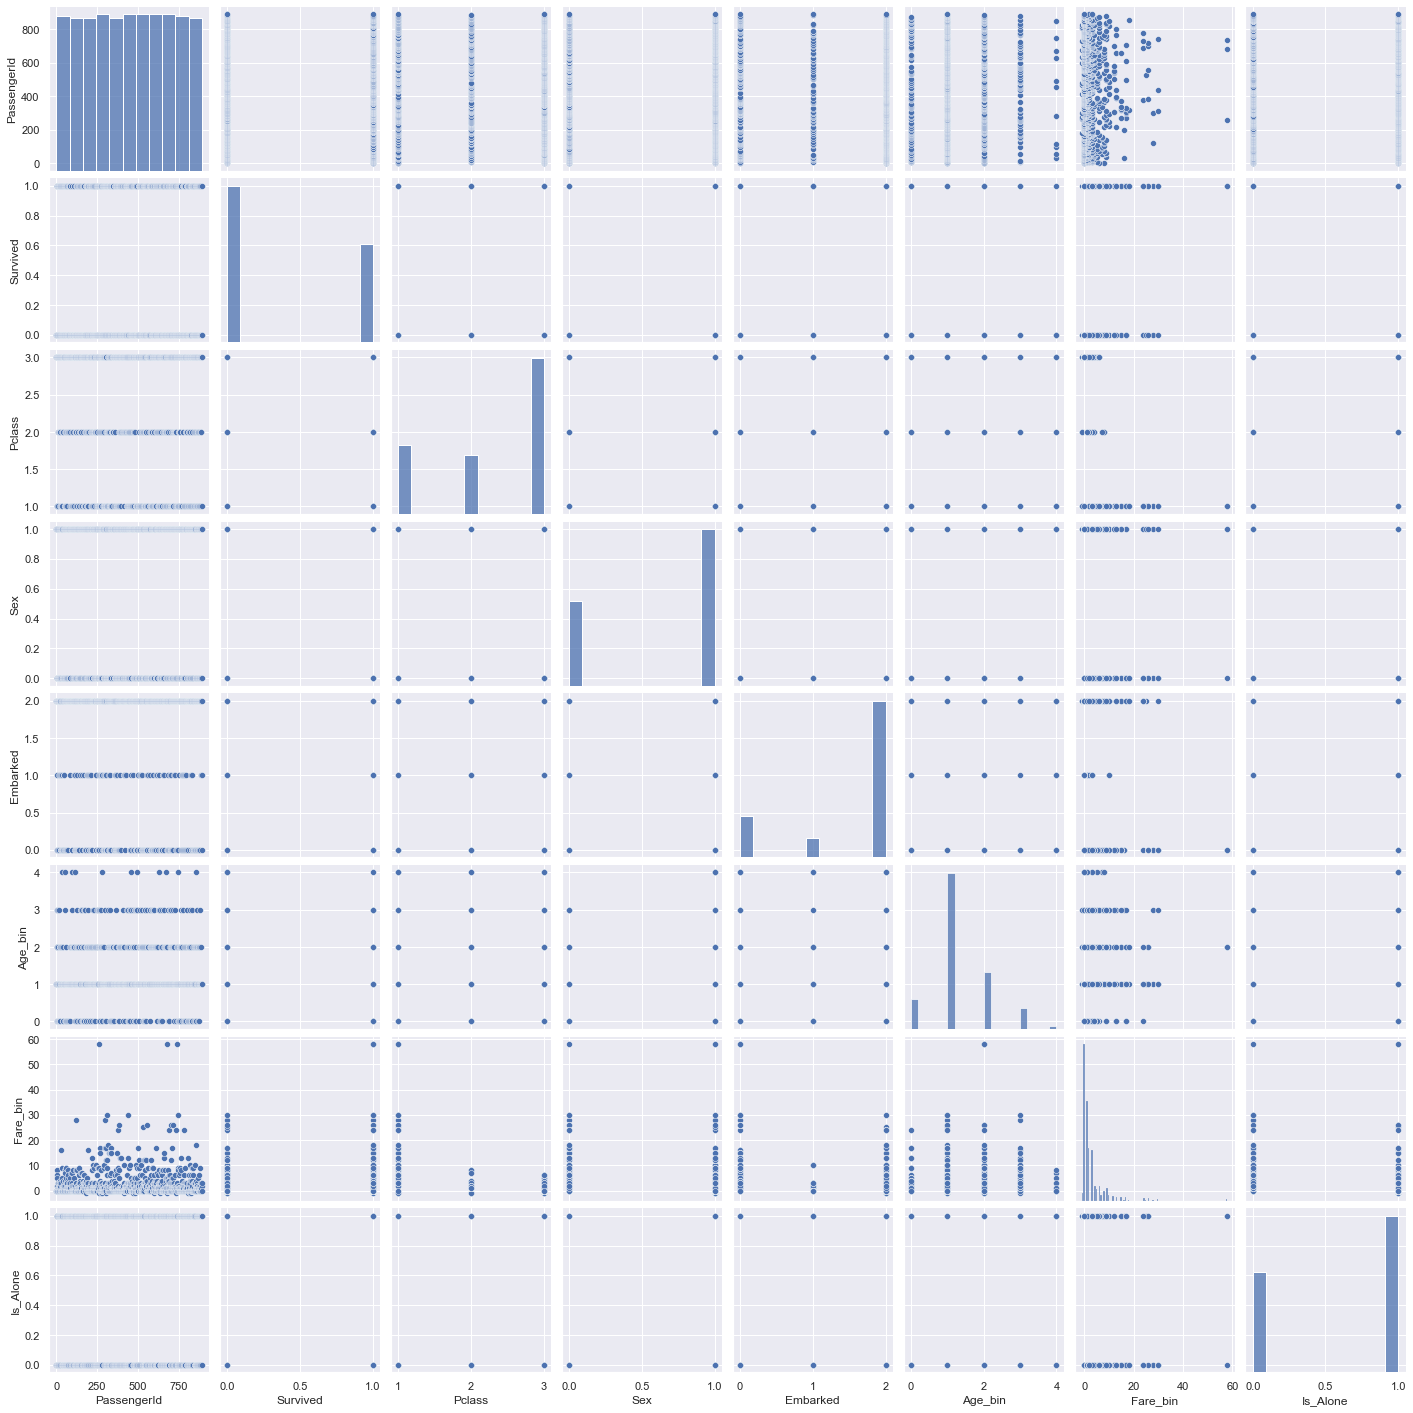

In [78]:
sns.pairplot(train_df);

##### Survived vs Sex

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


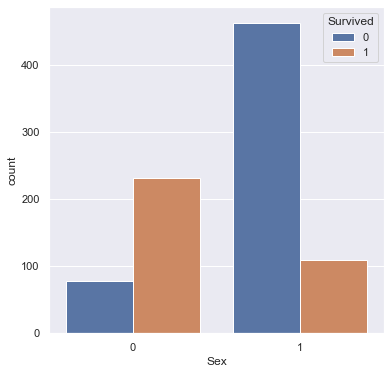

In [65]:
plt.figure(figsize=(6,6))
sns.countplot('Sex',hue='Survived',data=train_df);

##### Is_Alone vs Survived

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


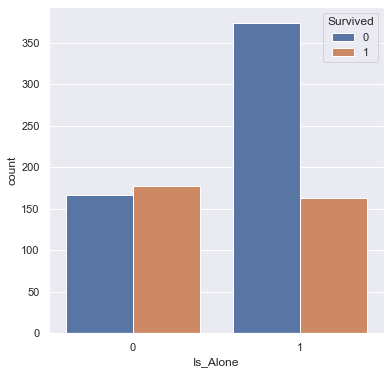

In [67]:
plt.figure(figsize=(6,6))
sns.countplot('Is_Alone',hue='Survived',data=train_df);

##### Pclass vs Survived

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


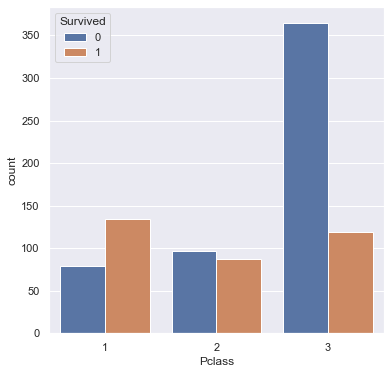

In [76]:
plt.figure(figsize=(6,6))
sns.countplot('Pclass',hue='Survived',data=train_df);

##### Scatter Plots

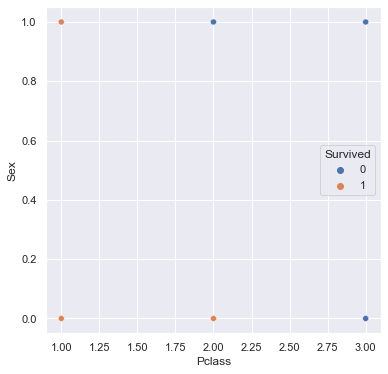

In [74]:
plt.figure(figsize=(6,6))
sns.scatterplot(y='Sex',x='Pclass',hue='Survived',data=train_df);

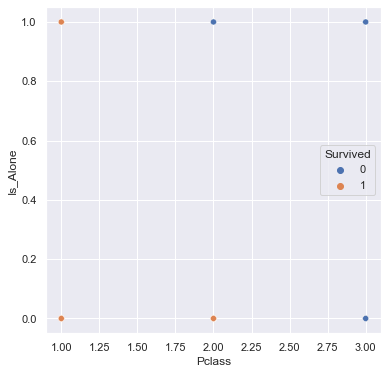

In [75]:
plt.figure(figsize=(6,6))
sns.scatterplot(y='',x='Pclass',hue='Survived',data=train_df);

## Check Correlation of features

##### a) Correlation with one another excluding the target variable

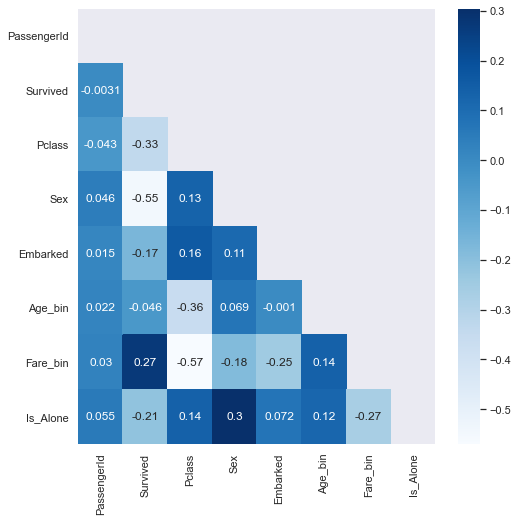

In [26]:
corr_matrix=train_df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool)),annot=True,cmap='Blues');

##### b) Correlation of features with the target variable

In [27]:
target_corr=train_df.corr()['Survived'].sort_values(ascending=False)
target_corr

Survived       1.000000
Fare_bin       0.270430
PassengerId   -0.003089
Age_bin       -0.045579
Embarked      -0.166252
Is_Alone      -0.211448
Pclass        -0.334097
Sex           -0.546015
Name: Survived, dtype: float64

## Feature Selection
_NOTE_: Here we do not have too many features and they are not well correlated to one another. So we consider all the features but 'PassengerId' because it doesn't determine who survives.

## Splitting and Normalization of data 

In [28]:
x_train,x_val,y_train,y_val=train_test_split(train_df.drop(['Survived','PassengerId'],axis=1),train_df['Survived'],test_size=0.2,random_state=200)

x_train=StandardScaler().fit_transform(x_train)
x_val=StandardScaler().fit_transform(x_val)


## DATA MODELLING

#### a) Random-Forest Classifier:

In [29]:
"""%%time 

random_params= {"n_estimators":np.arange(10,100,10),
         "max_depth":[None,3,5,10,20,40,50,100],
         "min_samples_split":np.arange(2,20,2),
         "min_samples_leaf":np.arange(1,20,2),
         "max_features":[0.5,1,"sqrt","auto"],
         "max_samples":[None]}


rs_model=RandomizedSearchCV(RandomForestClassifier(n_jobs=-1,random_state=200),
                            param_distributions=random_params,n_iter=100,
                            cv=5,verbose=True)


rs_model.fit(x_train,y_train)

rs_model.best_params_"""

'%%time \n\nrandom_params= {"n_estimators":np.arange(10,100,10),\n         "max_depth":[None,3,5,10,20,40,50,100],\n         "min_samples_split":np.arange(2,20,2),\n         "min_samples_leaf":np.arange(1,20,2),\n         "max_features":[0.5,1,"sqrt","auto"],\n         "max_samples":[None]}\n\n\nrs_model=RandomizedSearchCV(RandomForestClassifier(n_jobs=-1,random_state=200),\n                            param_distributions=random_params,n_iter=100,\n                            cv=5,verbose=True)\n\n\nrs_model.fit(x_train,y_train)\n\nrs_model.best_params_'

In [101]:
rs_model=RandomForestClassifier(n_jobs=-1,random_state=2,max_samples=None,n_estimators=60,min_samples_split= 2,
                            min_samples_leaf=3,max_features=0.5,max_depth=50)

rs_model.fit(x_train,y_train) 
y_train_pred=rs_model.predict(x_train)
print("TRAINING SCORE:",accuracy_score(y_train,y_train_pred),end=' ')

rs_model.fit(x_val,y_val)
y_val_pred_rs=rs_model.predict(x_val)
print("  VALIDATION SCORE:",accuracy_score(y_val,y_val_pred_rs))

TRAINING SCORE: 0.8693181818181818   VALIDATION SCORE: 0.8531073446327684


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


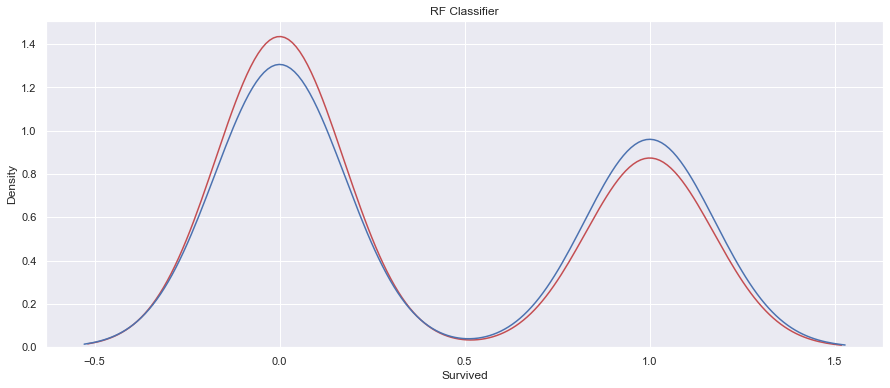

<Figure size 1080x432 with 0 Axes>

In [102]:
plt.figure(figsize=(15, 6))
plt.title("RF Classifier")
ax3 = sns.distplot(y_val_pred_rs,color='r',hist=False)
plt.figure(figsize=(15, 6))
sns.distplot(y_val,hist=False,color='b',ax=ax3)
plt.show()

##### b) K-Nearest Neighbours Classifier

In [31]:
"""%%time

n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)]   
weights = ['uniform','distance']
metric = ['euclidean','manhattan','chebyshev','seuclidean','minkowski'] 
knn_params = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric,
}

# run search
knn = KNeighborsClassifier() 
knn_model = RandomizedSearchCV(estimator = knn, random_state = 200,n_jobs = -1,param_distributions = knn_params,n_iter = 100, cv=5,verbose = True)
knn_model.fit(x_train,y_train)
knn_model.best_params_"""

"%%time\n\nn_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)]   \nweights = ['uniform','distance']\nmetric = ['euclidean','manhattan','chebyshev','seuclidean','minkowski'] \nknn_params = {\n    'n_neighbors': n_neighbors,\n    'weights': weights,\n    'metric': metric,\n}\n\n# run search\nknn = KNeighborsClassifier() \nknn_model = RandomizedSearchCV(estimator = knn, random_state = 200,n_jobs = -1,param_distributions = knn_params,n_iter = 100, cv=5,verbose = True)\nknn_model.fit(x_train,y_train)\nknn_model.best_params_"

In [98]:
knn_model=KNeighborsClassifier(weights='uniform', n_neighbors= 11, metric= 'euclidean')

knn_model.fit(x_train,y_train) 
y_train_pred=knn_model.predict(x_train)
print("TRAINING SCORE:",accuracy_score(y_train,y_train_pred),end=' ')

knn_model.fit(x_val,y_val)
y_val_pred_knn=knn_model.predict(x_val)
print("  VALIDATION SCORE:",accuracy_score(y_val,y_val_pred_knn))

TRAINING SCORE: 0.8139204545454546   VALIDATION SCORE: 0.8022598870056498


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


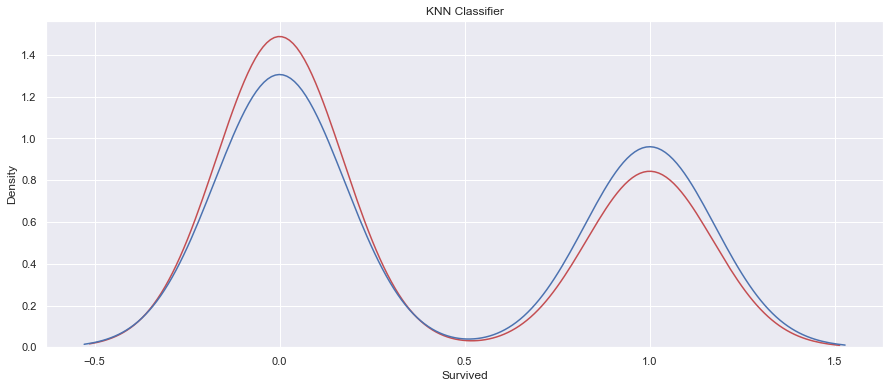

<Figure size 1080x432 with 0 Axes>

In [100]:
plt.figure(figsize=(15, 6))
plt.title("KNN Classifier")
ax3 = sns.distplot(y_val_pred_knn,color='r',hist=False)
plt.figure(figsize=(15, 6))
sns.distplot(y_val,hist=False,color='b',ax=ax3)
plt.show()

##### c) Decision Tree Classifier

In [33]:
"""%%time

DT_params = {"max_depth": [3,5,7,None],
              "max_features":randint(1, 9) ,
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
DT_model = RandomizedSearchCV(tree, param_distributions=DT_params, cv=5,verbose=True,random_state=200,n_jobs=-1,n_iter=100)

# Fit it to the data
DT_model.fit(x_train,y_train)
DT_model.best_params_"""

'%%time\n\nDT_params = {"max_depth": [3,5,7,None],\n              "max_features":randint(1, 9) ,\n              "min_samples_leaf": randint(1, 9),\n              "criterion": ["gini", "entropy"]}\n\n# Instantiate a Decision Tree classifier: tree\ntree = DecisionTreeClassifier()\n\n# Instantiate the RandomizedSearchCV object: tree_cv\nDT_model = RandomizedSearchCV(tree, param_distributions=DT_params, cv=5,verbose=True,random_state=200,n_jobs=-1,n_iter=100)\n\n# Fit it to the data\nDT_model.fit(x_train,y_train)\nDT_model.best_params_'

In [96]:
DT_model=DecisionTreeClassifier(criterion='entropy',max_depth=None,max_features=4,min_samples_leaf=1,random_state=1)

DT_model.fit(x_train,y_train) 
y_train_pred=DT_model.predict(x_train)
print("TRAINING SCORE:",accuracy_score(y_train,y_train_pred),end=' ')

DT_model.fit(x_val,y_val)
y_val_pred_dt=DT_model.predict(x_val)
print("  VALIDATION SCORE:",accuracy_score(y_val,y_val_pred_dt))

TRAINING SCORE: 0.8934659090909091   VALIDATION SCORE: 0.8870056497175142


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


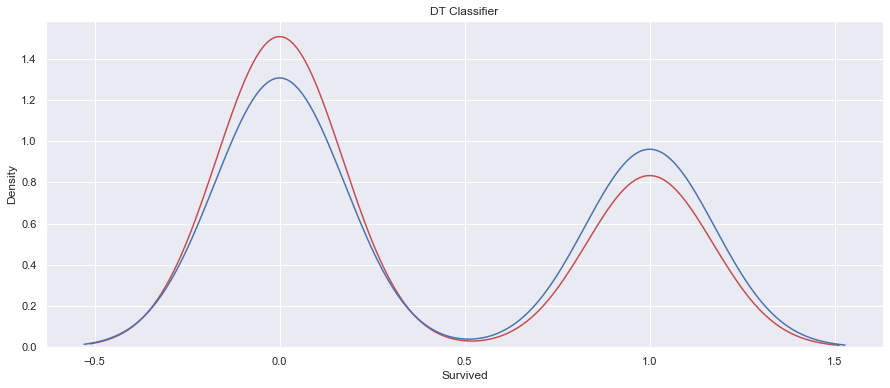

<Figure size 1080x432 with 0 Axes>

In [97]:
plt.figure(figsize=(15, 6))
plt.title("DT Classifier")
ax3 = sns.distplot(y_val_pred_dt,color='r',hist=False)
plt.figure(figsize=(15, 6))
sns.distplot(y_val,hist=False,color='b',ax=ax3)
plt.show()

##### d) Logistic Regression

In [35]:
"""%%time

LR_params={'solver' : ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag'],'penalty': ['none', 'l1', 'l2', 'elasticnet'],'C': loguniform(1e-5, 100)}

LR_model=RandomizedSearchCV(LogisticRegression(),param_distributions=LR_params,n_jobs=-1,random_state=200,cv=5,verbose=True,n_iter=100)

LR_model.fit(x_train,y_train)
LR_model.best_params_"""

"%%time\n\nLR_params={'solver' : ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag'],'penalty': ['none', 'l1', 'l2', 'elasticnet'],'C': loguniform(1e-5, 100)}\n\nLR_model=RandomizedSearchCV(LogisticRegression(),param_distributions=LR_params,n_jobs=-1,random_state=200,cv=5,verbose=True,n_iter=100)\n\nLR_model.fit(x_train,y_train)\nLR_model.best_params_"

In [92]:
LR_model=LogisticRegression( C= 0.09449327079757, penalty= 'l2', solver= 'sag')

LR_model.fit(x_train,y_train) 
y_train_pred=LR_model.predict(x_train)
print("TRAINING SCORE:",accuracy_score(y_train,y_train_pred),end=' ')

LR_model.fit(x_val,y_val)
y_val_pred_lr=LR_model.predict(x_val)
print("  VALIDATION SCORE:",accuracy_score(y_val,y_val_pred_lr))

TRAINING SCORE: 0.7982954545454546   VALIDATION SCORE: 0.7909604519774012


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


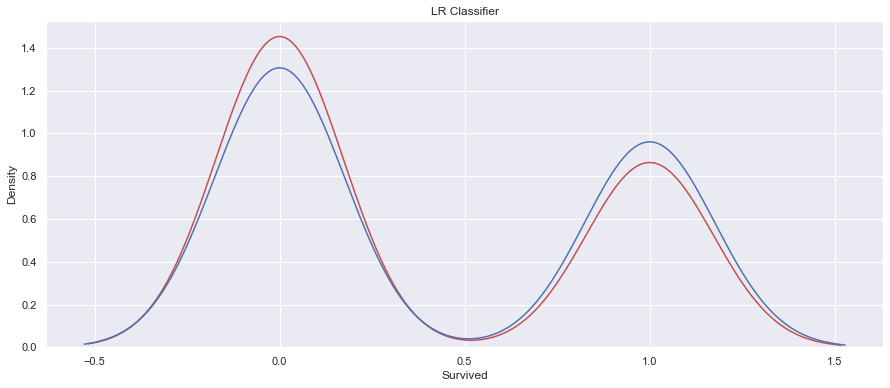

<Figure size 1080x432 with 0 Axes>

In [94]:
plt.figure(figsize=(15, 6))
plt.title("LR Classifier")
ax3 = sns.distplot(y_val_pred_lr,color='r',hist=False)
plt.figure(figsize=(15, 6))
sns.distplot(y_val,hist=False,color='b',ax=ax3)
plt.show()

##### e) SVM

In [37]:
"""%%time

svc_params={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['auto', 1e-3, 1e-4],'C': [0.01, .1, 1, 10, 100, 1000],
            'class_weight': [{0: 0.01}, {1: 1}, {1: 2}, {1: 10}, {1: 50}, 'balanced']}

svc_model=RandomizedSearchCV(SVC(),param_distributions=svc_params,n_iter=100,n_jobs=-1,random_state=200,cv=5,verbose=True)

svc_model.fit(x_train,y_train)
svc_model.best_params_"""

"%%time\n\nsvc_params={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['auto', 1e-3, 1e-4],'C': [0.01, .1, 1, 10, 100, 1000],\n            'class_weight': [{0: 0.01}, {1: 1}, {1: 2}, {1: 10}, {1: 50}, 'balanced']}\n\nsvc_model=RandomizedSearchCV(SVC(),param_distributions=svc_params,n_iter=100,n_jobs=-1,random_state=200,cv=5,verbose=True)\n\nsvc_model.fit(x_train,y_train)\nsvc_model.best_params_"

In [88]:
svc_model=SVC(kernel= 'poly', gamma='auto', class_weight= {1: 1}, C= 4)

svc_model.fit(x_train,y_train) 
y_train_pred=svc_model.predict(x_train)
print("TRAINING SCORE:",accuracy_score(y_train,y_train_pred),end=' ')

svc_model.fit(x_val,y_val)
y_val_pred_svc=svc_model.predict(x_val)
print("  VALIDATION SCORE:",accuracy_score(y_val,y_val_pred_svc))

TRAINING SCORE: 0.8394886363636364   VALIDATION SCORE: 0.8361581920903954


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


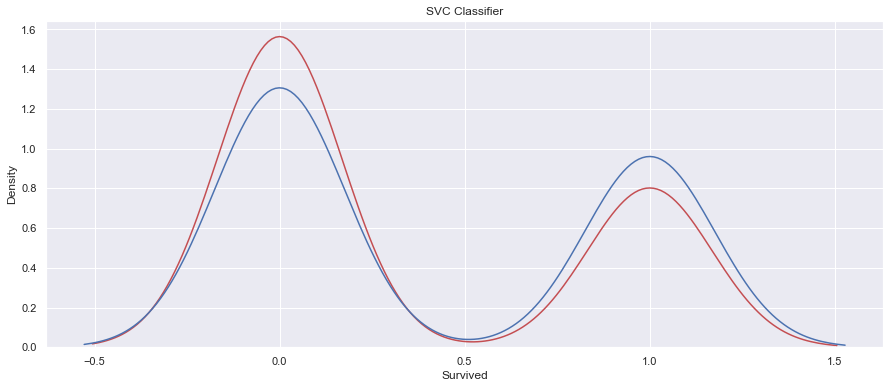

<Figure size 1080x432 with 0 Axes>

In [90]:
plt.figure(figsize=(15, 6))
plt.title("SVC Classifier")
ax3 = sns.distplot(y_val_pred_svc,color='r',hist=False)
plt.figure(figsize=(15, 6))
sns.distplot(y_val,hist=False,color='b',ax=ax3)
plt.show()

##### XGB Classifier

In [39]:
"""%%time

clf_xgb =XGBClassifier(objective = 'binary:logistic')
xgb_params = {'n_estimators': sts.randint(150, 1000),
              'learning_rate': sts.uniform(0.01, 0.6),
              'subsample': sts.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': sts.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

xgb_model = RandomizedSearchCV(clf_xgb, 
                         param_distributions = xgb_params,
                         cv = 5,  
                         n_iter = 100,
                         error_score = 0, 
                         verbose = True, 
                         n_jobs = -1,random_state=200)

xgb_model.fit(x_train,y_train)

xgb_model.best_params_"""

"%%time\n\nclf_xgb =XGBClassifier(objective = 'binary:logistic')\nxgb_params = {'n_estimators': sts.randint(150, 1000),\n              'learning_rate': sts.uniform(0.01, 0.6),\n              'subsample': sts.uniform(0.3, 0.9),\n              'max_depth': [3, 4, 5, 6, 7, 8, 9],\n              'colsample_bytree': sts.uniform(0.5, 0.9),\n              'min_child_weight': [1, 2, 3, 4]\n             }\n\nxgb_model = RandomizedSearchCV(clf_xgb, \n                         param_distributions = xgb_params,\n                         cv = 5,  \n                         n_iter = 100,\n                         error_score = 0, \n                         verbose = True, \n                         n_jobs = -1,random_state=200)\n\nxgb_model.fit(x_train,y_train)\n\nxgb_model.best_params_"

In [85]:
xgb_model=XGBClassifier(colsample_bytree= 0.9470635428873291,
 learning_rate= 0.97515098281902677,
 max_depth=3,
 min_child_weight=1,
 n_estimators= 600,
 subsample= 0.9323601337048126)

xgb_model.fit(x_train,y_train) 
y_train_pred_xgb=xgb_model.predict(x_train)
print("TRAINING SCORE:",accuracy_score(y_train,y_train_pred),end=' ')

xgb_model.fit(x_val,y_val)
y_val_pred_xgb=xgb_model.predict(x_val)
print("  VALIDATION SCORE:",accuracy_score(y_val,y_val_pred_xgb))

TRAINING SCORE: 0.8892045454545454   VALIDATION SCORE: 0.8870056497175142


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


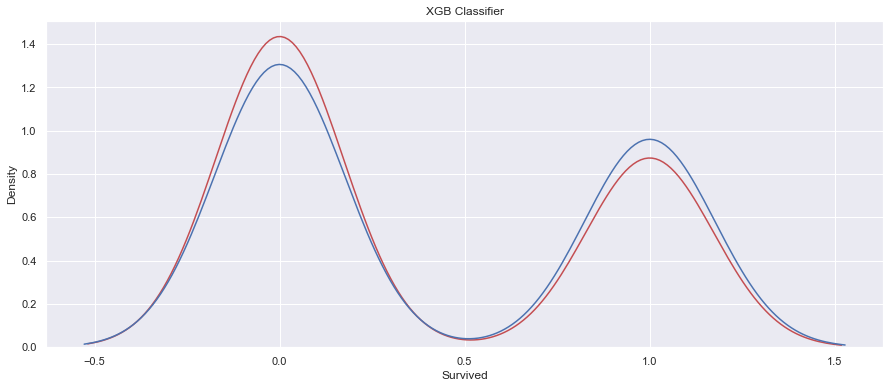

<Figure size 1080x432 with 0 Axes>

In [86]:
plt.figure(figsize=(15, 6))
plt.title("XGB Classifier")
ax3 = sns.distplot(y_val_pred_xgb,color='r',hist=False)
plt.figure(figsize=(15, 6))
sns.distplot(y_val,hist=False,color='b',ax=ax3)
plt.show()

## Check the best Model on the Test.csv, i.e the new dataset

#### Finally we see that the Models  XGB Classifier and Decision Tree give the best results and XGB gives a slightly better result than Decision Tree. Hence we go with XGB Classifier for Test.csv for new dataset

In [41]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### Outlier Detection

In [42]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices) 
    l=[]
    
    for k,v in outlier_indices.items():
        if v>n:
            l.append(k)
    multiple_outliers = l
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop_in_test = detect_outliers(test_df,2,["Age","SibSp","Parch","Fare"])

#locate the outliers
test_df.loc[Outliers_to_drop_in_test] # Show the outliers rows

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


### Feature Engineering

In [43]:
test_df.drop(['Cabin','Ticket','Name'],axis=1,inplace=True)

In [44]:
for i in test_df.columns:
    if pd.api.types.is_numeric_dtype(test_df[i].values):
        if pd.isnull(test_df[i].values).any():
            test_df[i].fillna((test_df[i]).median(),inplace=True)

In [45]:
for i in test_df.columns:
    if pd.api.types.is_object_dtype(test_df[i].values):
        if pd.isnull(test_df[i].values).any():
            print(i)
            test_df[i].fillna(test_df[i].mode().values[0],inplace=True)

In [46]:
for i in test_df.columns:
    if pd.api.types.is_float_dtype(test_df[i].values):
        if pd.isnull(test_df[i].values).any():
            test_df[i].fillna((test_df[i]).median(),inplace=True)

In [47]:
test_df.isnull().sum()/len(test_df)

PassengerId    0.0
Pclass         0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Fare           0.0
Embarked       0.0
dtype: float64

In [48]:
test_df['Age'].sort_values(ascending=False)

96     76.00
81     67.00
236    64.00
179    64.00
305    64.00
       ...  
250     0.92
307     0.83
281     0.75
201     0.33
354     0.17
Name: Age, Length: 418, dtype: float64

In [49]:
bins=np.linspace(test_df['Age'].min(),test_df['Age'].max(),6) # if we want n bins then we divide by n+1 
label_age=[1,2,3,4,5]
test_df['Age_bin']=pd.cut(test_df['Age'],bins,labels=label_age,include_lowest=True)
test_df.drop(['Age'],axis=1,inplace=True)
test_df

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age_bin
0,892,3,male,0,0,7.8292,Q,3
1,893,3,female,1,0,7.0000,S,4
2,894,2,male,0,0,9.6875,Q,5
3,895,3,male,0,0,8.6625,S,2
4,896,3,female,1,1,12.2875,S,2
...,...,...,...,...,...,...,...,...
413,1305,3,male,0,0,8.0500,S,2
414,1306,1,female,0,0,108.9000,C,3
415,1307,3,male,0,0,7.2500,S,3
416,1308,3,male,0,0,8.0500,S,2


In [50]:
test_df['Fare'].sort_values(ascending=False).head(30)

343    512.3292
69     263.0000
53     263.0000
24     262.3750
375    262.3750
59     262.3750
64     262.3750
142    262.3750
184    247.5208
202    227.5250
114    221.7792
156    221.7792
81     221.7792
74     211.5000
407    211.5000
218    211.5000
75     211.5000
324    211.3375
400    164.8667
217    164.8667
306    151.5500
141    151.5500
316    146.5208
272    136.7792
252    136.7792
314    135.6333
371    134.5000
196    134.5000
242    134.5000
414    108.9000
Name: Fare, dtype: float64

In [51]:
bins=np.linspace(test_df['Fare'].min(),test_df['Fare'].max(),60) # if we want n bins then we divide by n+1 
test_df['Fare_bin']=pd.cut(test_df['Fare'],bins,include_lowest=False)
test_df.drop('Fare',axis=1,inplace=True)
test_df

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,Age_bin,Fare_bin
0,892,3,male,0,0,Q,3,"(0.0, 8.684]"
1,893,3,female,1,0,S,4,"(0.0, 8.684]"
2,894,2,male,0,0,Q,5,"(8.684, 17.367]"
3,895,3,male,0,0,S,2,"(0.0, 8.684]"
4,896,3,female,1,1,S,2,"(8.684, 17.367]"
...,...,...,...,...,...,...,...,...
413,1305,3,male,0,0,S,2,"(0.0, 8.684]"
414,1306,1,female,0,0,C,3,"(104.203, 112.886]"
415,1307,3,male,0,0,S,3,"(0.0, 8.684]"
416,1308,3,male,0,0,S,2,"(0.0, 8.684]"


In [52]:
test_df['Family_members_Excluding_Person']=test_df['SibSp']+test_df['Parch']
list=[]
for i in test_df['Family_members_Excluding_Person'].values:
    if i==0:
        list.append('Yes')
    else:
        list.append('No')

test_df['Is_Alone']=list
test_df

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,Age_bin,Fare_bin,Family_members_Excluding_Person,Is_Alone
0,892,3,male,0,0,Q,3,"(0.0, 8.684]",0,Yes
1,893,3,female,1,0,S,4,"(0.0, 8.684]",1,No
2,894,2,male,0,0,Q,5,"(8.684, 17.367]",0,Yes
3,895,3,male,0,0,S,2,"(0.0, 8.684]",0,Yes
4,896,3,female,1,1,S,2,"(8.684, 17.367]",2,No
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,male,0,0,S,2,"(0.0, 8.684]",0,Yes
414,1306,1,female,0,0,C,3,"(104.203, 112.886]",0,Yes
415,1307,3,male,0,0,S,3,"(0.0, 8.684]",0,Yes
416,1308,3,male,0,0,S,2,"(0.0, 8.684]",0,Yes


In [53]:
test_df.drop('Family_members_Excluding_Person',axis=1,inplace=True)
test_df.drop(['SibSp','Parch'],axis=1,inplace=True)
test_df

,PassengerId,Pclass,Sex,Embarked,Age_bin,Fare_bin,Is_Alone
0,892,3,male,Q,3,"(0.0, 8.684]",Yes
1,893,3,female,S,4,"(0.0, 8.684]",No
2,894,2,male,Q,5,"(8.684, 17.367]",Yes
3,895,3,male,S,2,"(0.0, 8.684]",Yes
4,896,3,female,S,2,"(8.684, 17.367]",No
...,...,...,...,...,...,...,...
413,1305,3,male,S,2,"(0.0, 8.684]",Yes
414,1306,1,female,C,3,"(104.203, 112.886]",Yes
415,1307,3,male,S,3,"(0.0, 8.684]",Yes
416,1308,3,male,S,2,"(0.0, 8.684]",Yes


In [54]:
for i in test_df.columns:
    if not pd.api.types.is_numeric_dtype(test_df[i].values):
        test_df[i]=pd.Categorical(test_df[i]).codes
test_df

,PassengerId,Pclass,Sex,Embarked,Age_bin,Fare_bin,Is_Alone
0,892,3,1,1,2,0,1
1,893,3,0,2,3,0,0
2,894,2,1,1,4,1,1
3,895,3,1,2,1,0,1
4,896,3,0,2,1,1,0
...,...,...,...,...,...,...,...
413,1305,3,1,2,1,0,1
414,1306,1,0,0,2,12,1
415,1307,3,1,2,2,0,1
416,1308,3,1,2,1,0,1


### Prediction of survivors using the best model

In [59]:
x_test=StandardScaler().fit_transform(test_df.drop('PassengerId',axis=1))

In [60]:
TEST_Predict=xgb_model.predict(x_test)
TEST_Predict

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [61]:
test_df["survived"]=TEST_Predict
l=[]
for i in test_df["survived"].values:
    if i==0:
        l.append('NO')
    else:
        l.append('YES')

test_df["SURVIVED?"]=l
test_df.drop('survived',axis=1,inplace=True)
test_df

,PassengerId,Pclass,Sex,Embarked,Age_bin,Fare_bin,Is_Alone,SURVIVED?
0,892,3,1,1,2,0,1,NO
1,893,3,0,2,3,0,0,NO
2,894,2,1,1,4,1,1,NO
3,895,3,1,2,1,0,1,NO
4,896,3,0,2,1,1,0,NO
...,...,...,...,...,...,...,...,...
413,1305,3,1,2,1,0,1,NO
414,1306,1,0,0,2,12,1,YES
415,1307,3,1,2,2,0,1,NO
416,1308,3,1,2,1,0,1,NO
